In [1]:
from fastai.collab import *
from fastai.tabular.all import *
from time import *

# Daily weather in antwerp dataset

In [2]:
path = Path('.')
path.ls()

(#16) [Path('.git'),Path('SolarEnergyDataRefine.ipynb'),Path('SolarEnergyRefine_v2.ipynb'),Path('SolarEnergy.zip'),Path('weather_in_Antwerp_future2.csv'),Path('Weather.zip'),Path('README.md'),Path('SolarEnergyDataRefine.html'),Path('models'),Path('PV_Elec_Gas3.csv')...]

Weather dataset was downloaded from Kaggle, the author is Rami Ma (https://www.kaggle.com/ramima/weather-dataset-in-antwerp-belgium).

In [3]:
weather = pd.read_csv(path/'weather_in_Antwerp.csv', delimiter=';', engine='python', header=0)

In [4]:
weather.head()

,Unnamed: 0,clock,temp,weather,wind,humidity,barometer,visibility,year,month,day
0,0,00:20,11 °C,Mostly cloudy.,17 km/h,94%,1011 mbar,5 km,2012,1,1
1,1,00:50,12 °C,Mostly cloudy.,17 km/h,88%,1011 mbar,NaN,2012,1,1
2,2,01:50,12 °C,Overcast.,19 km/h,88%,1011 mbar,9 km,2012,1,1
3,3,02:20,12 °C,Partly cloudy.,17 km/h,88%,1010 mbar,NaN,2012,1,1
4,4,02:50,12 °C,Sprinkles. Mostly cloudy.,15 km/h,88%,1010 mbar,NaN,2012,1,1


As shown in the table above, data were collected also during the night. These stats do not have any meaning since there is no sun, thus no energy generated at night. Futhermore, having them in the training dataset can significantly reduce the quality of the model. Assuming that there is completely no sun between 22:00 and 04:00 of the next day, rows whose 'clock' belongs to this time interval are removed:

In [5]:
for i in range(len(weather)):
    if int(weather['clock'][i][0:2]) < 4 or int(weather['clock'][i][0:2]) > 22: 
        weather.drop(index=i, axis=0, inplace=True)

After removing night time data, the number of rows left in the table is:

In [6]:
len(weather)

106159

In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106159 entries, 7 to 133666
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  106159 non-null  int64 
 1   clock       106159 non-null  object
 2   temp        106145 non-null  object
 3   weather     106156 non-null  object
 4   wind        106121 non-null  object
 5   humidity    105867 non-null  object
 6   barometer   106152 non-null  object
 7   visibility  47984 non-null   object
 8   year        106159 non-null  int64 
 9   month       106159 non-null  int64 
 10  day         106159 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 9.7+ MB


There are 106159 lines of data in total and visibility row has only 47984 lines of non-null data, which means over 50% of that column are null and hence have no value in training a machine learning model. So, let drop this column out of the table.

In [8]:
weather.drop('visibility', axis=1, inplace=True)

In [9]:
weather.drop('Unnamed: 0', axis=1, inplace=True)
weather.head()

,clock,temp,weather,wind,humidity,barometer,year,month,day
7,04:20,11 °C,Light rain. Mostly cloudy.,17 km/h,94%,1010 mbar,2012,1,1
8,04:50,11 °C,Sprinkles. Mostly cloudy.,17 km/h,94%,1010 mbar,2012,1,1
9,05:20,12 °C,Low clouds.,22 km/h,88%,1010 mbar,2012,1,1
10,05:50,12 °C,Sprinkles. Mostly cloudy.,19 km/h,88%,1010 mbar,2012,1,1
11,06:20,12 °C,Fog.,19 km/h,88%,1010 mbar,2012,1,1


In [10]:
#Form the date column 
def create_date(table):    
    table['date'] = table.apply(lambda row:
                                    f'{row.year}-{row.month}-{row.day}', axis=1)
    table.date = pd.to_datetime(table.date)
    return table.drop(['year', 'month', 'day'], axis = 1)

weather = create_date(weather)
weather.head()

,clock,temp,weather,wind,humidity,barometer,date
7,04:20,11 °C,Light rain. Mostly cloudy.,17 km/h,94%,1010 mbar,2012-01-01
8,04:50,11 °C,Sprinkles. Mostly cloudy.,17 km/h,94%,1010 mbar,2012-01-01
9,05:20,12 °C,Low clouds.,22 km/h,88%,1010 mbar,2012-01-01
10,05:50,12 °C,Sprinkles. Mostly cloudy.,19 km/h,88%,1010 mbar,2012-01-01
11,06:20,12 °C,Fog.,19 km/h,88%,1010 mbar,2012-01-01


Now the table has a 'date' column and 'clock' column, which indicate the moment in the day that the data were collected. Let have a look at the number of unique values that exist in each column.

In [11]:
weather['clock'].value_counts()

11:50    2847
17:50    2846
16:50    2844
16:20    2839
12:50    2837
12:20    2835
06:50    2833
10:50    2831
13:50    2827
11:20    2827
18:50    2822
10:20    2822
05:50    2817
19:50    2814
18:20    2814
15:20    2807
07:50    2806
17:20    2806
21:20    2801
09:20    2795
20:50    2792
06:20    2791
14:50    2788
08:50    2786
07:20    2782
04:50    2780
04:20    2774
09:50    2766
13:20    2763
22:50    2762
15:50    2760
19:20    2756
05:20    2750
22:20    2746
21:50    2743
14:20    2726
08:20    2713
20:20    2711
Name: clock, dtype: int64

In [12]:
len(weather['date'].unique())

2865

It is obvious that a lot of data are missing. There are to option to 'fix' this: 1) Filling in the gap with average value of the moment right before and right after it, or 2) Gathering all data during day into 3 groups: Morning, Midday and Afternoon then calculate the everage value for each group.

Option 1 will keep all data while option 2 will considerably simplify the data. Note that solar energy production datapublished by Frank (https://www.kaggle.com/fvcoppen/solarpanelspower) contains daily data, having more data during day also means that there will be more independant variables in a single sample. It leads to the need of more traning epoches, and (probably) more data when traing a machine learning model.

For now, let use the second option. If the output of the model is not good enough, the use of the first solution will be considered.

The data need to be cleaned before calculations are made, starting by removeing all unit from numerical data.

In [13]:
def clean_wind(obj):
    if isinstance(obj, str):
        if obj == 'No wind':
            obj = 0
        else:
            obj = obj.replace(' km/h','')
    return obj

def clean_temp(obj):
    if isinstance(obj, str):
        obj = obj.replace('\xa0°C','')
    return obj
    
def clean_humidity(obj):
    if isinstance(obj, str):
        obj = obj.replace('%', '')
    return obj

def clean_barometer(obj):
    if isinstance(obj, str):
        obj = obj.replace(' mbar', '')
    return obj

In [14]:
def trans_data(table):
    table['temp'] = (table['temp'].apply(clean_temp)).astype(float)    
    table['wind'] = (table['wind'].apply(clean_wind)).astype(float)
    table['humidity'] = (table['humidity'].apply(clean_humidity)).astype(float)
    table['barometer'] = (table['barometer'].apply(clean_barometer)).astype(float)
    return table

In [15]:
weather_tran = trans_data(weather)
weather_tran.reset_index(inplace=True)
weather_tran.head()

,index,clock,temp,weather,wind,humidity,barometer,date
0,7,04:20,11.0,Light rain. Mostly cloudy.,17.0,94.0,1010.0,2012-01-01
1,8,04:50,11.0,Sprinkles. Mostly cloudy.,17.0,94.0,1010.0,2012-01-01
2,9,05:20,12.0,Low clouds.,22.0,88.0,1010.0,2012-01-01
3,10,05:50,12.0,Sprinkles. Mostly cloudy.,19.0,88.0,1010.0,2012-01-01
4,11,06:20,12.0,Fog.,19.0,88.0,1010.0,2012-01-01


'weather' column sometimes contains more than one word. A quick look through the column may help finding whether a common rule is used to describe the weather.

In [16]:
weather_tran['weather'].unique()

array(['Light rain. Mostly cloudy.', 'Sprinkles. Mostly cloudy.',
       'Low clouds.', 'Fog.', 'Sprinkles. Overcast.', 'Mostly cloudy.',
       'Sprinkles. More clouds than sun.', 'Cloudy.',
       'Light rain. Overcast.', 'Light rain. More clouds than sun.',
       'Light rain. Cloudy.', 'Overcast.', 'Light rain. Broken clouds.',
       'Sprinkles. Passing clouds.', 'Light rain. Partly cloudy.',
       'Partly cloudy.', 'Light rain. Passing clouds.', 'Passing clouds.',
       'Scattered clouds.', 'Clear.', 'Partly sunny.',
       'Light rain. Partly sunny.', 'Light rain. Fog.', 'Rain. Fog.',
       'Rain. Passing clouds.', 'Broken clouds.',
       'Sprinkles. Partly cloudy.', 'Heavy rain. Partly cloudy.',
       'Rain showers. Broken clouds.', 'Rain showers. Partly cloudy.',
       'More clouds than sun.', 'Sprinkles. Low clouds.',
       'Sprinkles. Fog.', 'Sprinkles. Broken clouds.', 'Ice fog.',
       'Chilly.', 'Light fog.', 'Sunny.', 'Cold.',
       'Drizzle. Partly sunny.', 'Dr

It is easy to see that whenever the weather status is formed by two words, the first words will describe the rain/snow while the second word gives information about cloud status. In addition, there is always a dot at the end of each word.

Based on the finding above, the 'weather' columns can be split into two column named 'cloud' and 'rain'.

In [17]:
def seperate_weather(weather_in):
    # Create a list to temporary rain status
    rain_list = ['No rain']*len(weather_in)

    for i in range(len(weather_in)):
        if str(weather_in.loc[i, 'weather']) != 'nan':
            weather_list = weather_in.loc[i, 'weather'].split('.')
        
            # The weather always ends with a '.'
            # Hence, a single weather status will return a 2-member list
            if len(weather_list) > 2:
                rain_list[i] = weather_list[0].strip()
                weather_in.loc[i, 'weather'] = weather_list[1].strip()
            elif len(weather_list) == 2:
                weather_in.loc[i, 'weather'] = weather_list[0].strip()
        else:
            rain_list[i] = weather_in.loc[i, 'weather']
    
    # Add the rain column next to the weather column
    weather_in.insert(2, "rain", rain_list, True)
    
    # Rename the weather column to 'cloud'
    weather_in.rename(columns = {'weather':'cloud'}, inplace = True)

In [18]:
weather_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106159 entries, 0 to 106158
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   index      106159 non-null  int64         
 1   clock      106159 non-null  object        
 2   temp       106145 non-null  float64       
 3   weather    106156 non-null  object        
 4   wind       106121 non-null  float64       
 5   humidity   105867 non-null  float64       
 6   barometer  106152 non-null  float64       
 7   date       106159 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 6.5+ MB


In [19]:
seperate_weather(weather_tran)
weather_tran.head()

,index,clock,rain,temp,cloud,wind,humidity,barometer,date
0,7,04:20,Light rain,11.0,Mostly cloudy,17.0,94.0,1010.0,2012-01-01
1,8,04:50,Sprinkles,11.0,Mostly cloudy,17.0,94.0,1010.0,2012-01-01
2,9,05:20,No rain,12.0,Low clouds,22.0,88.0,1010.0,2012-01-01
3,10,05:50,Sprinkles,12.0,Mostly cloudy,19.0,88.0,1010.0,2012-01-01
4,11,06:20,No rain,12.0,Fog,19.0,88.0,1010.0,2012-01-01


In [20]:
weather_tran.drop('index', axis=1, inplace=True)

The next step is filling missing values. For temp, wind, humidity and barometer, each missing value is replaced by the everage of the same data from two samples right before and after it.

In [21]:
for d in ['temp','wind','humidity','barometer']:
    for i in range(len(weather_tran)):
        if str(weather_tran.loc[i, d]) == 'nan':
            n = 1
            while str(weather_tran.loc[i-n, d]) == 'nan':
                n = n + 1
            m = 1
            while str(weather_tran.loc[i+m, d]) == 'nan':
                m = m + 1
            weather_tran.loc[i, d] = (weather_tran.loc[i-n, d] + weather_tran.loc[i+m, d])/2

weather_tran.isna().sum() 

clock        0
rain         3
temp         0
cloud        3
wind         0
humidity     0
barometer    0
date         0
dtype: int64

Rows whose 'rain' and 'cloud' are NaN can get the value from the row next to it.

In [22]:
for i in range(len(weather_tran)):
    if str(weather_tran.loc[i, 'cloud']) == 'nan':
        weather_tran.loc[i, 'cloud'] = weather_tran.loc[i-1, 'cloud']
        weather_tran.loc[i, 'rain'] = weather_tran.loc[i-1, 'rain']        

In [23]:
weather_tran.isna().sum() 

clock        0
rain         0
temp         0
cloud        0
wind         0
humidity     0
barometer    0
date         0
dtype: int64

In [24]:
weather_tran['rain'].unique()

array(['Light rain', 'Sprinkles', 'No rain', 'Rain', 'Heavy rain',
       'Rain showers', 'Drizzle', 'Scattered showers', 'Light snow',
       'Snow flurries', 'Snow', 'Light mixture of precip',
       'Light freezing rain', 'Thunderstorms', 'Thundershowers',
       'Strong thunderstorms', 'Lots of rain', 'Snow showers',
       'Freezing rain', 'Sleet', 'Hail'], dtype=object)

In [25]:
weather_tran['cloud'].unique()

array(['Mostly cloudy', 'Low clouds', 'Fog', 'Overcast',
       'More clouds than sun', 'Cloudy', 'Broken clouds',
       'Passing clouds', 'Partly cloudy', 'Scattered clouds', 'Clear',
       'Partly sunny', 'Ice fog', 'Chilly', 'Light fog', 'Sunny', 'Cold',
       'Frigid', 'Dense fog', 'Quite Cool', 'Haze', 'Cool', 'Mild',
       'Quite cool', 'Sandstorm'], dtype=object)

The rain and cloud description must be changed to have the same format with data return from OpenWeatherAPI.

In [26]:
def reduce_cloud_categories(weather):
    weather.cloud = weather.cloud.map({
        'Fog':'overcast clouds',
        'Ice fog':'overcast clouds',
        'Haze':'overcast clouds',
        'Clear':'clear sky',
        'Sunny':'clear sky',
        'Broken clouds':'broken clouds',
        'Scattered clouds':'scattered clouds',
        'Overcast':'overcast clouds',
        'More clouds than sun':'broken clouds',
        'Partly cloudy':'broken clouds',
        'Low clouds':'few clouds',
        'Mostly cloudy':'overcast clouds',
        'Cloudy':'overcast clouds',
        'Passing clouds':'broken clouds',
        'Partly sunny':'few clouds',
        'Mostly sunny':'clear sky',
        'Chilly':'few clouds',
        'Light fog':'overcast clouds',
        'Cold':'few clouds',
        'Frigid':'few clouds',
        'Dense fog':'overcast clouds',
        'Quite Cool':'few clouds',
        'Quite cool':'few clouds',
        'Cool':'few clouds',
        'Mild':'few clouds',
        'Sandstorm':'overcast clouds'
    },na_action='ignore')
    return weather

In [27]:
def reduce_rain_categories(weather):
    weather.rain = weather.rain.map({
        'Thundershowers':'thunderstorms',
        'Thunderstorms':'thunderstorms',
        'Strong thunderstorms':'thunderstorms',
        'Drizzle':'drizzle',
        'Light rain':'rain',
        'Rain':'rain',
        'Sprinkles':'rain',
        'Scattered showers':'rain',
        'Light freezing rain':'rain',
        'Freezing rain':'rain',
        'Rain showers':'rain',
        'Heavy rain':'rain',
        'Lots of rain':'rain',
        'Snow':'snow',
        'Sleet':'snow',
        'Hail':'snow',
        'Snow showers':'snow',
        'Snow flurries':'snow',
        'Light mixture of precip':'snow',
        'Light snow':'snow',
        'No rain':'no rain'
    },na_action='ignore')
    return weather

In [28]:
weather_buffer = weather_tran
weather_simplified = reduce_rain_categories(weather_buffer)
weather_simplified = reduce_cloud_categories(weather_buffer)

In [38]:
weather_simplified.head()

,clock,rain,temp,cloud,wind,humidity,barometer,date
0,04:20,rain,11.0,overcast clouds,17.0,94.0,1010.0,2012-01-01
1,04:50,rain,11.0,overcast clouds,17.0,94.0,1010.0,2012-01-01
2,05:20,no rain,12.0,few clouds,22.0,88.0,1010.0,2012-01-01
3,05:50,rain,12.0,overcast clouds,19.0,88.0,1010.0,2012-01-01
4,06:20,no rain,12.0,overcast clouds,19.0,88.0,1010.0,2012-01-01


In [39]:
weather_simplified.isna().sum()

clock        0
rain         0
temp         0
cloud        0
wind         0
humidity     0
barometer    0
date         0
dtype: int64

Now the dataset is ready for calculation. As mentioned above, there will be 3 time intervals:<br>
- morning: before 11:00<br>
- noon: from 11:00 to 16:00<br>
- afternoon: after 16:00<br>

Temperature, Wind speed, Humidity are mean values. Rain and Cloud status of a period are values that show up the most in that period.

In [41]:
weather_simplified.sort_values(by=['date','clock'], inplace=True)
weather_simplified.reset_index(inplace=True)

In [42]:
weather_simplified.drop('index', axis=1, inplace=True)
weather_simplified.head()

,clock,rain,temp,cloud,wind,humidity,barometer,date
0,04:20,rain,11.0,overcast clouds,17.0,94.0,1010.0,2012-01-01
1,04:50,rain,11.0,overcast clouds,17.0,94.0,1010.0,2012-01-01
2,05:20,no rain,12.0,few clouds,22.0,88.0,1010.0,2012-01-01
3,05:50,rain,12.0,overcast clouds,19.0,88.0,1010.0,2012-01-01
4,06:20,no rain,12.0,overcast clouds,19.0,88.0,1010.0,2012-01-01


In [43]:
#To find the value with the most apperance
def most_frequent(List): 
    return max(set(List), key = List.count) 

In [44]:
def simplify_data(weather):
    new_data = pd.DataFrame(columns = ['date', 
                                       'morning_temp','morning_wind','morning_humidity','morning_rain','morning_cloud',
                                       'noon_temp','noon_wind','noon_humidity','noon_rain','noon_cloud',
                                       'afternoon_temp', 'afternoon_wind', 'afternoon_humidity', 'afternoon_rain', 'afternoon_cloud'])
    
    mor_count, mor_temp, mor_humid, mor_wind = [0]*4
    noo_count, noo_temp, noo_humid, noo_wind = [0]*4
    aft_count, aft_temp, aft_humid, aft_wind = [0]*4
    
    mor_rain=[np.nan]
    mor_cloud=[np.nan]
    noo_rain=[np.nan]
    noo_cloud=[np.nan]
    aft_rain=[np.nan]
    aft_cloud=[np.nan]
    
    current_date = weather.loc[0, 'date']
    
    for i in range(len(weather)):
        if weather.loc[i, 'date'] != current_date:
            new_data = new_data.append({
                'date':pd.to_datetime(current_date),
                'morning_temp':mor_temp/mor_count if mor_count != 0 else np.nan,
                'morning_humidity':mor_humid/mor_count if mor_count != 0 else np.nan,
                'morning_wind':mor_wind/mor_count if mor_count != 0 else np.nan,
                'morning_rain':most_frequent(mor_rain),
                'morning_cloud':most_frequent(mor_cloud),
                'noon_temp':noo_temp/noo_count if noo_count != 0 else np.nan,
                'noon_humidity':noo_humid/noo_count if noo_count != 0 else np.nan,
                'noon_wind':noo_wind/noo_count if noo_count != 0 else np.nan,
                'noon_rain':most_frequent(noo_rain),
                'noon_cloud':most_frequent(noo_cloud),
                'afternoon_temp':aft_temp/aft_count if aft_count != 0 else np.nan,
                'afternoon_humidity':aft_humid/aft_count if aft_count != 0 else np.nan,
                'afternoon_wind':aft_wind/aft_count if aft_count != 0 else np.nan,
                'afternoon_rain':most_frequent(aft_rain),
                'afternoon_cloud':most_frequent(aft_cloud)
            }, ignore_index=True)
            
            mor_count, mor_temp, mor_humid, mor_wind = [0]*4
            noo_count, noo_temp, noo_humid, noo_wind = [0]*4
            aft_count, aft_temp, aft_humid, aft_wind = [0]*4
    
            mor_rain=[np.nan]
            mor_cloud=[np.nan]
            noo_rain=[np.nan]
            noo_cloud=[np.nan]
            aft_rain=[np.nan]
            aft_cloud=[np.nan]
        
            current_date = weather.loc[i, 'date']
        
        if int(weather.loc[i, 'clock'][0:2]) < 11:
            mor_count += 1
            mor_temp += weather.loc[i, 'temp']
            mor_humid += weather.loc[i, 'humidity']
            mor_wind += weather.loc[i, 'wind']
            mor_rain.append(weather.loc[i,'rain'])
            mor_cloud.append(weather.loc[i, 'cloud'])
        elif int(weather.loc[i, 'clock'][0:2]) < 16:
            noo_count += 1
            noo_temp += weather.loc[i, 'temp']
            noo_humid += weather.loc[i, 'humidity']
            noo_wind += weather.loc[i, 'wind']
            noo_rain.append(weather.loc[i,'rain'])
            noo_cloud.append(weather.loc[i, 'cloud'])
        else:
            aft_count += 1
            aft_temp += weather.loc[i, 'temp']
            aft_humid += weather.loc[i, 'humidity']
            aft_wind += weather.loc[i, 'wind']
            aft_rain.append(weather.loc[i,'rain'])
            aft_cloud.append(weather.loc[i, 'cloud'])
            
    return new_data
    

In [45]:
weather_new = simplify_data(weather_tran)

In [46]:
weather_new.isna().sum()

date                  0
morning_temp          1
morning_wind          1
morning_humidity      1
morning_rain          1
morning_cloud         1
noon_temp             0
noon_wind             0
noon_humidity         0
noon_rain             1
noon_cloud            1
afternoon_temp        0
afternoon_wind        0
afternoon_humidity    0
afternoon_rain        1
afternoon_cloud       1
dtype: int64

In [47]:
weather_new = weather_new.dropna()

In [48]:
weather_new.reset_index()
weather_new.head()

,date,morning_temp,morning_wind,morning_humidity,morning_rain,morning_cloud,noon_temp,noon_wind,noon_humidity,noon_rain,noon_cloud,afternoon_temp,afternoon_wind,afternoon_humidity,afternoon_rain,afternoon_cloud
0,2012-01-01,11.846154,19.384615,90.769231,no rain,overcast clouds,12.900000,19.000000,88.600000,no rain,overcast clouds,13.076923,27.000000,87.538462,rain,overcast clouds
1,2012-01-02,8.071429,15.214286,84.285714,no rain,broken clouds,8.555556,19.333333,79.333333,no rain,broken clouds,6.071429,17.285714,76.214286,no rain,clear sky
2,2012-01-03,6.857143,32.500000,80.428571,no rain,broken clouds,10.700000,43.100000,82.200000,rain,few clouds,9.642857,32.071429,74.071429,no rain,broken clouds
3,2012-01-04,7.000000,28.714286,67.785714,no rain,broken clouds,7.700000,25.200000,67.500000,no rain,broken clouds,7.785714,26.142857,76.357143,no rain,broken clouds
4,2012-01-05,9.384615,40.230769,81.461538,rain,broken clouds,8.777778,41.111111,69.888889,no rain,broken clouds,6.444444,38.333333,73.777778,no rain,broken clouds


In [49]:
len(weather_new)

2862

2862 comparing with 2865 days at the beginning. It means that 3 rows of data containing NaN value were discarded.

/home/nhat/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


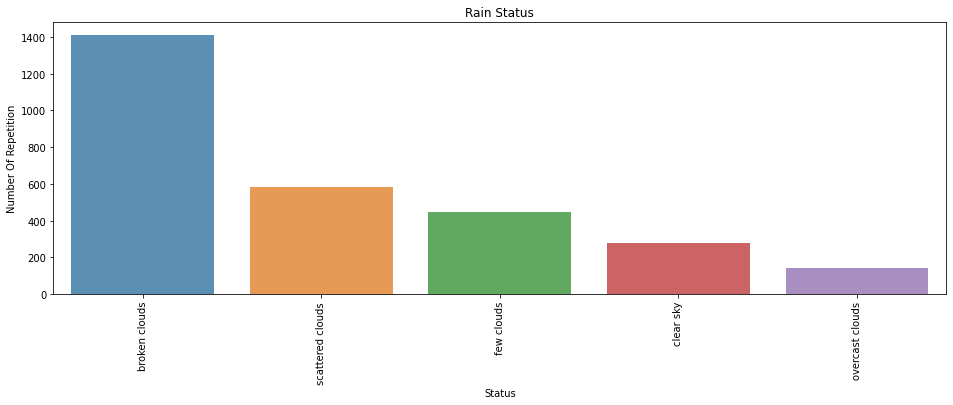

In [53]:
import seaborn as sns
weather_counts = weather_new['noon_cloud'].value_counts()
plt.figure(figsize=(16,5))
sns.barplot(weather_counts.index, weather_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Rain Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

At this moment, the weather dataset is already at its finest form. In following steps, the energy data will be processed.

# Daily solar power production in Antwerp dataset

The dataset is provided by Frank, a Kaggle user (https://www.kaggle.com/fvcoppen/solarpanelspower).

In [54]:
energy = pd.read_csv(path/'PV_Elec_Gas3.csv', delimiter=',', engine='python', header=0)

In [55]:
energy.head()

,date,Cumulative_solar_power,kWh electricity/day,Gas/day
0,26/10/2011,0.1,15.1,9.0
1,27/10/2011,10.2,7.4,9.2
2,28/10/2011,20.2,5.8,8.0
3,29/10/2011,29.6,4.9,6.6
4,30/10/2011,34.2,11.7,5.3


In [56]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3304 entries, 0 to 3303
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    3304 non-null   object 
 1   Cumulative_solar_power  3304 non-null   float64
 2   kWh electricity/day     3304 non-null   float64
 3   Gas/day                 3304 non-null   float64
dtypes: float64(3), object(1)
memory usage: 103.4+ KB


In [57]:
weather_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2862 entries, 0 to 2863
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                2862 non-null   datetime64[ns]
 1   morning_temp        2862 non-null   float64       
 2   morning_wind        2862 non-null   float64       
 3   morning_humidity    2862 non-null   float64       
 4   morning_rain        2862 non-null   object        
 5   morning_cloud       2862 non-null   object        
 6   noon_temp           2862 non-null   float64       
 7   noon_wind           2862 non-null   float64       
 8   noon_humidity       2862 non-null   float64       
 9   noon_rain           2862 non-null   object        
 10  noon_cloud          2862 non-null   object        
 11  afternoon_temp      2862 non-null   float64       
 12  afternoon_wind      2862 non-null   float64       
 13  afternoon_humidity  2862 non-null   float64     

Two datasets will be merged using the 'date' column. Therefore, data data of the energy production table must be casted to datetime64

In [58]:
energy.date = pd.to_datetime(energy.date)
energy.set_index(['date'], inplace=True)       #change the index
energy.head()

,Cumulative_solar_power,kWh electricity/day,Gas/day
date,,,
2011-10-26,0.1,15.1,9.0
2011-10-27,10.2,7.4,9.2
2011-10-28,20.2,5.8,8.0
2011-10-29,29.6,4.9,6.6
2011-10-30,34.2,11.7,5.3


The solar power production is the only thing that matter, hence the other two shiuld be removed.

In [59]:
energy.drop(labels='kWh electricity/day', axis=1, inplace=True)
energy.drop(labels='Gas/day', axis=1, inplace=True)
energy.rename(columns = {'Cumulative_solar_power':'cum_power'}, inplace = True)
energy.head()

,cum_power
date,
2011-10-26,0.1
2011-10-27,10.2
2011-10-28,20.2
2011-10-29,29.6
2011-10-30,34.2


According to the description of the dataset, data were recorded at the beginning of days. Therfore, the info in the table actually describes the cum_power in the previous day. Since the purpose of this project is to find out the relationship between weather and daily energy production, the daily number also needs to be calculated from accumulate data.

In [60]:
energy = energy.shift(periods=-1, freq='D', axis=0) #step one day back

power_list = [0] * len(energy)
power_list[0] = energy['cum_power'][0]

for i in range(len(energy)-1):
    power_list[i+1] = energy['cum_power'][i+1] - energy['cum_power'][i]

energy.insert(1, "daily_power", power_list, True)
energy.drop(labels='cum_power', axis=1, inplace=True)

In [61]:
energy.head()

,daily_power
date,
2011-10-25,0.1
2011-10-26,10.1
2011-10-27,10.0
2011-10-28,9.4
2011-10-29,4.6


The data in the first row is not correct, it must be discarded.

In [65]:
energy = energy.iloc[1:]

In [66]:
energy.head()

,daily_power
date,
2011-10-26,10.1
2011-10-27,10.0
2011-10-28,9.4
2011-10-29,4.6
2011-10-30,3.8


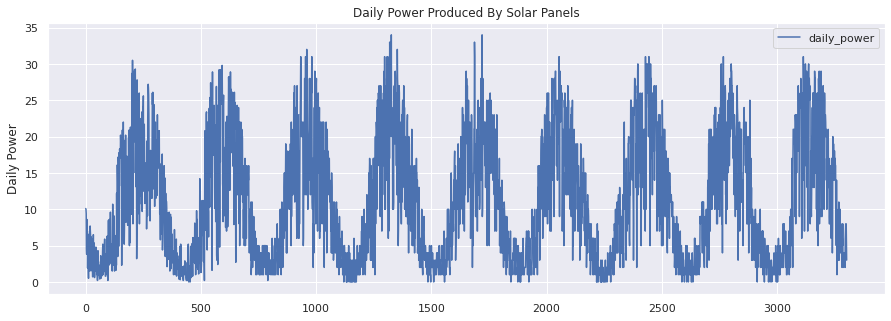

In [67]:
sns.set()
power_index= energy.reset_index()

power_index.plot(y='daily_power', figsize=(15,5))

plt.title('Daily Power Produced By Solar Panels')
plt.ylabel('Daily Power')
plt.show()

This is interesting. Because it show how the energy production varies during years. The recorded data reaches its peak during the summer and drop to bottom in the winter.

In [68]:
def merge_weatherANDpower():
    dataset = weather_new.merge(energy, on=['date'])
    return dataset.set_index('date')

final_dataset = merge_weatherANDpower()
final_dataset.head()

,morning_temp,morning_wind,morning_humidity,morning_rain,morning_cloud,noon_temp,noon_wind,noon_humidity,noon_rain,noon_cloud,afternoon_temp,afternoon_wind,afternoon_humidity,afternoon_rain,afternoon_cloud,daily_power
date,,,,,,,,,,,,,,,,
2012-01-01,11.846154,19.384615,90.769231,no rain,overcast clouds,12.900000,19.000000,88.600000,no rain,overcast clouds,13.076923,27.000000,87.538462,rain,overcast clouds,5.6
2012-01-02,8.071429,15.214286,84.285714,no rain,broken clouds,8.555556,19.333333,79.333333,no rain,broken clouds,6.071429,17.285714,76.214286,no rain,clear sky,2.5
2012-01-03,6.857143,32.500000,80.428571,no rain,broken clouds,10.700000,43.100000,82.200000,rain,few clouds,9.642857,32.071429,74.071429,no rain,broken clouds,7.6
2012-01-04,7.000000,28.714286,67.785714,no rain,broken clouds,7.700000,25.200000,67.500000,no rain,broken clouds,7.785714,26.142857,76.357143,no rain,broken clouds,15.1
2012-01-05,9.384615,40.230769,81.461538,rain,broken clouds,8.777778,41.111111,69.888889,no rain,broken clouds,6.444444,38.333333,73.777778,no rain,broken clouds,13.1


In [69]:
len(final_dataset)

2862

Some rows from power dataset are gone because the weather dataset has fewer samples. Let have an overall look at the data.

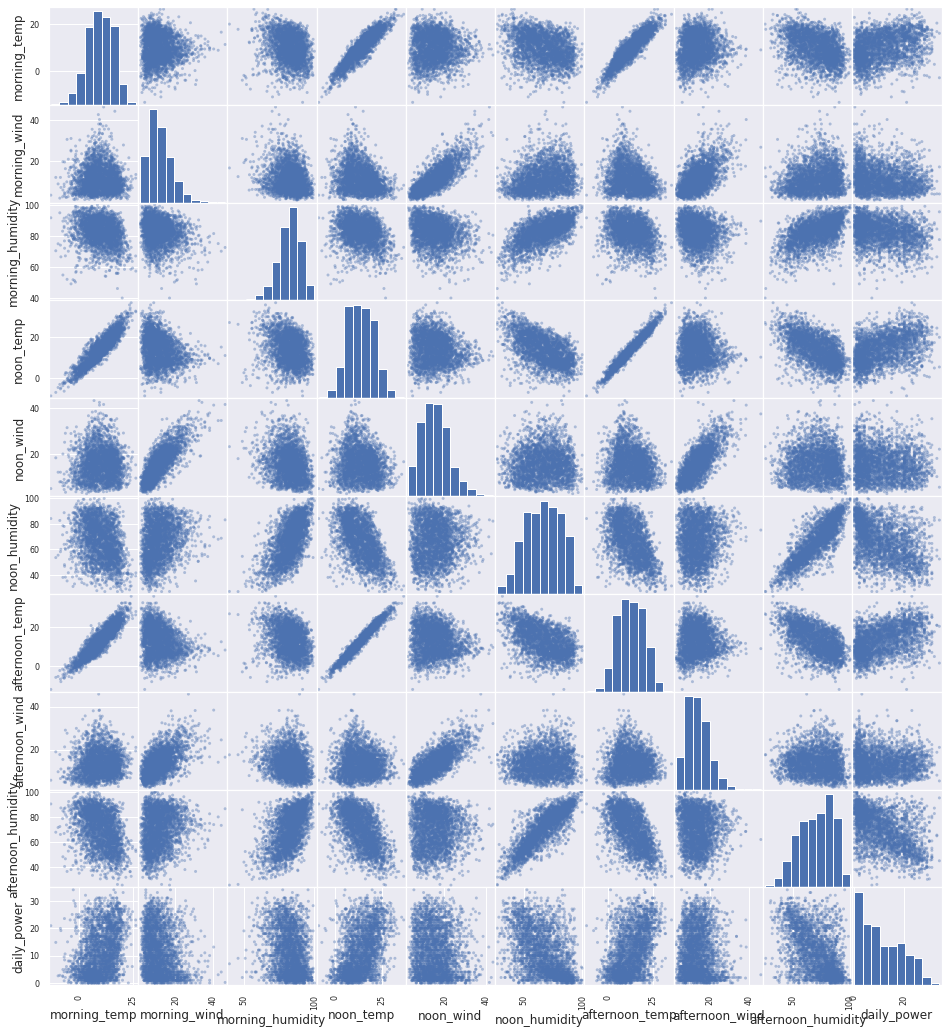

In [70]:
from pandas.plotting import scatter_matrix 
scatter_matrix(final_dataset, figsize=(16,18), alpha=0.4) 
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


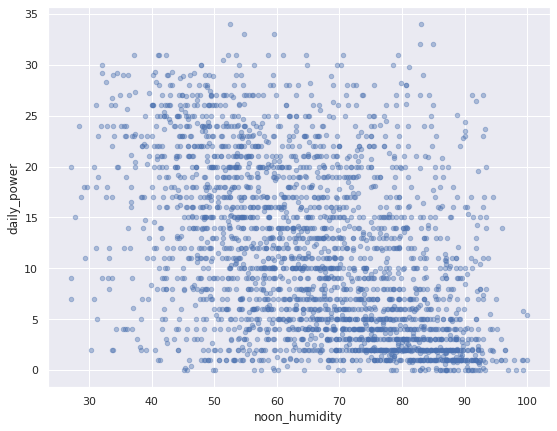

In [71]:
final_dataset.plot(kind='scatter', x= 'noon_humidity',y='daily_power', figsize=(9,7), alpha=0.4) 
plt.show()

Data look a little "unatural". The daily_power have too many integer recoded-values. This can be fixed by adding a tiny value to samples which are integer.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


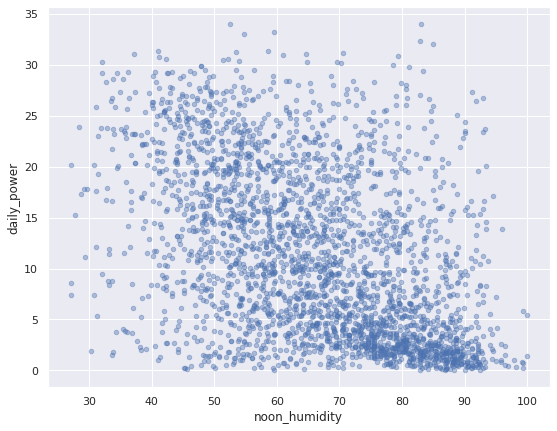

In [73]:
#To delete data anomalies
import random
final_dataset.daily_power = final_dataset.daily_power.apply(lambda x: x+random.randint(0,50)/100 if x==0 else x)
for i in range(1,34):
    final_dataset.daily_power = final_dataset.daily_power.apply(lambda x: x+random.randint(-50,50)/100 if x==i else x)
final_dataset.plot(kind='scatter', x= 'noon_humidity',y='daily_power', figsize=(9,7), alpha=0.4) 
plt.show()

In [75]:
final_dataset.to_csv('training_data_v2.csv')